In [1]:
import sys
sys.path.insert(0, './scripts')

# now read in the new function
from helpers import get_data, mean_abs_error
from preprocessor import preprocessor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create Model Object

Now this is the fun part, where all our careful work to ensure we lived into good code standards pays off. We'll use a Scikit-Learn Pipeline to combine the preprocessing and GBM steps into one package.

The pipeline object called my_model implements fit and predict methods (among others). When we call the fit method, the pipeline will execute preprocessor.fit_transform() on the data we pass in the arguments, then pass that result to GradientBoostingRegressor.fit(). Similarly, when we call the predict method, it will execute preprocessor.transform() and then GradientBoostingRegressor.predict().

Another major benefit of living into the fit, transform, predict paradigm of Scikit-Learn is that you can add other preprocessing steps (like PCA or some other feature transformation) into the pipeline with little modification to existing code. Finally, if any of the steps required parameter tuning (like chosing the number of principal components to use in your model), you can tune them all at once by implementing the steps in a pipeline then using a parameter selection method like Grid Search on the entire pipeline. Look through some examples in the documentation linked above for further reading.

In [3]:
p = preprocessor(cols_to_filter = ['rawcensustractandblock', 'censustractandblock', 'propertyzoningdesc', 
                                 'regionidneighborhood', 'regionidzip', 'parcelid'], datecols=['transactiondate'])

gbm = GradientBoostingRegressor(n_estimators = 1000, learning_rate=0.1, max_depth=2, loss='lad', subsample=0.5)

my_model = Pipeline([('preprocessor', p), ('regressor', gbm)])

# Fit Final Model

Because we've written good code up to this point, these steps are really interpretable and easy to read.

In [4]:
X_train, y_train = get_data('train')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3291: DtypeWarning: Columns (22,32,34,49,55) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
my_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 <preprocessor.preprocessor object at 0x1a1d7667b8>),
                ('regressor',
                 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                           criterion='friedman_mse', init=None,
                                           learning_rate=0.1, loss='lad',
                                           max_depth=2, max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=1000,
                                           n_iter_no_change=None,
                 

# Score Test Dataset

We should only do this once or a handful of times because it's possible to overfit the test set. Remember this is the test dataset that was released after the competition was over, but is not the same format as what is scored as part of the competition. Our final evaluation will be making a Kaggle submission, however we can use this test set to visualize our model results on an out-of-time test set, meaning this data is from another time period as the data we trained the model on.

In [6]:
X_test, y_test = get_data('test')
y_pred = my_model.predict(X_test)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3291: DtypeWarning: Columns (49) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Evaluate Model



In [7]:
# using the naive median prediction method
mean_abs_error(y_test, y_train.median())

0.06970475324840694

In [8]:
# using our actual model
mean_abs_error(y_test, y_pred)

0.06925115218531339

# Plot the Model Results


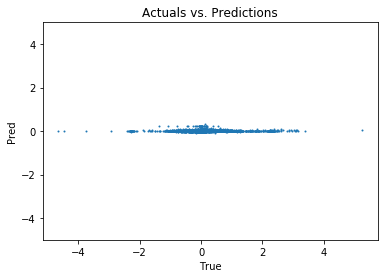

In [9]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, s=1)
ax.set_title('Actuals vs. Predictions')
ax.set_xlabel('True')
ax.set_ylabel('Pred')
ax.set_ylim(-5, 5)
plt.show()

This plot shows exactly where our lack of predictive power is coming from: our model is predicting everything really close to the average or median (probably median given our choice of loss function) instead of making useful predictions.

Distribution of Actuals and Predictions

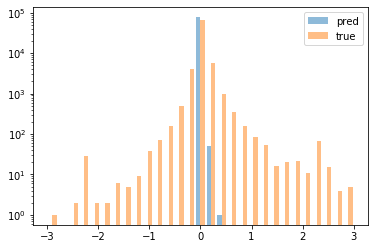

In [10]:
def plot_hists(y_pred, y_true):

    fig, ax = plt.subplots()
    bins = np.linspace(-3, 3, 30)
    ax.hist([y_pred, y_true], label=['pred', 'true'], alpha=0.5, bins=bins, log=True)
    plt.legend(loc='upper right')
    plt.show()
    
plot_hists(y_pred, y_test)

Notice also how the model predictions have far less variance that our true response values

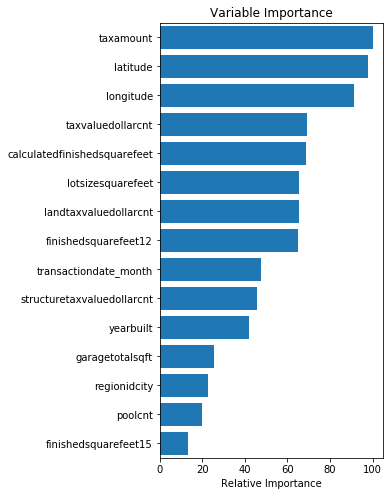

In [11]:
def feat_imp_plot(sk_model, feat_names, N_feature):


    feature_importance = sk_model.feature_importances_
    feature_importance = 100.0 * feature_importance / feature_importance.max()
    sorted_idx = np.argsort(feature_importance)
    total_features = sorted_idx.shape[0]
    pos = np.arange(total_features) + .5

    fig, ax = plt.subplots(figsize=(4,8))
    ax.barh(pos, feature_importance[sorted_idx], align='center')
    ax.set_yticks(pos)
    ax.set_yticklabels(fnames[sorted_idx])
    ax.set_ylim(total_features-N_feature, total_features)
    ax.set_xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    
fnames = my_model.steps[0][1].transform(pd.DataFrame(X_test.iloc[0]).T).columns
feat_imp_plot(my_model.steps[1][1], fnames, 15)


Remember, these feature importances are on the model for predicting the error between the Zestimate and the actual sale price, so you could conclude that the features are the ones Zillow's model aren't fully capturing signal from

In [2]:
!mkdir -p models